In [2]:
%matplotlib inline

import datetime

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

import utide

print(utide.__version__)

0.3.0


C:\Users\hp\AppData\Roaming\Python\Python38\site-packages\pkg_resources\__init__.py:123: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release
  warnings.warn(


In [3]:
# prompt: !pip install utide

import os

# Check if UTide directory exists, if not, clone it
# if not os.path.exists('UTide'):
#     !git clone https://github.com/wesleybowman/UTide.git

# Add UTide to the Python path
import sys
sys.path.insert(0, 'UTide')

import utide

utide.__version__

'0.3.0'

In [1]:
!pip install utide

     ---------------------------------------- 75.2/75.2 kB ? eta 0:00:00



[notice] A new release of pip available: 22.2.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [42]:
with open("./notebooks/can1998.dtf") as f:
    lines = f.readlines()

print("".join(lines[:5]))

FileNotFoundError: [Errno 2] No such file or directory: './notebooks/can1998.dtf'

In [54]:
import pandas as pd

obs = pd.read_csv(
    'dataProcessed/ABE5Y1_processed.csv',
    usecols=['time', 'Water_Level_LAT'],
    na_values='9.990'
)

obs['time'] = pd.to_datetime(obs['time'])
obs = obs.set_index('time')
print(obs.head(5))




                     Water_Level_LAT
time                                
2019-01-01 00:00:00            3.163
2019-01-01 00:15:00            2.997
2019-01-01 00:30:00            2.907
2019-01-01 00:45:00            2.706
2019-01-01 01:00:00            2.585


In [55]:
import pandas as pd

# 假设您的数据已存储在DataFrame中，名为obs
print(obs['Water_Level_LAT'].describe())


count    175296.000000
mean          2.617417
std           0.999701
min          -0.962000
25%           1.797000
50%           2.620000
75%           3.461000
max           5.120000
Name: Water_Level_LAT, dtype: float64


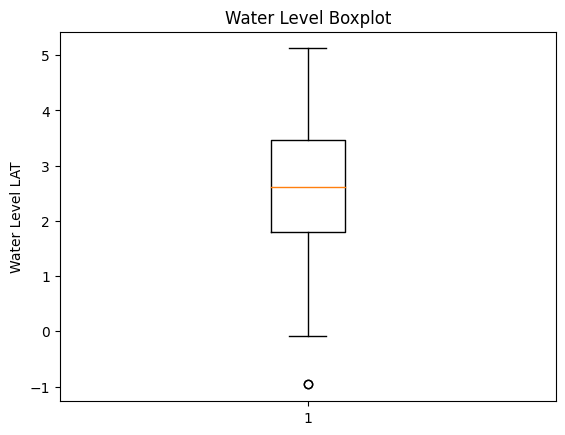

In [56]:
import matplotlib.pyplot as plt

# 绘制箱线图
plt.boxplot(obs['Water_Level_LAT'].dropna())
plt.title('Water Level Boxplot')
plt.ylabel('Water Level LAT')
plt.show()


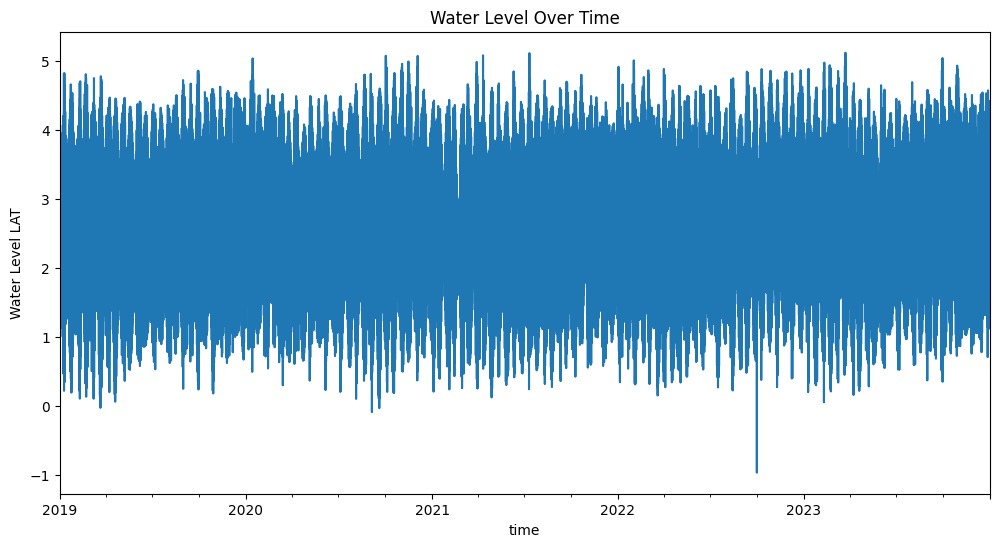

In [57]:
# 如果数据按时间索引
obs['Water_Level_LAT'].plot(figsize=(12, 6))
plt.title('Water Level Over Time')
plt.ylabel('Water Level LAT')
plt.show()


In [58]:
from scipy import stats

# Grubbs检验
def grubbs_test(data, alpha=0.05):
    n = len(data)
    mean = data.mean()
    std = data.std()
    G_calculated = abs(data - mean) / std
    threshold = ((n - 1) / np.sqrt(n)) * np.sqrt((stats.t.ppf(1 - alpha / (2 * n), n - 2)**2) / (n - 2 + stats.t.ppf(1 - alpha / (2 * n), n - 2)**2))
    outliers = data[G_calculated > threshold]
    return outliers

outliers_grubbs = grubbs_test(obs['Water_Level_LAT'].dropna())

print("根据Grubbs检验检测到的离群值如下：")
print(outliers_grubbs)


根据Grubbs检验检测到的离群值如下：
Series([], Name: Water_Level_LAT, dtype: float64)


In [59]:
import pandas as pd
import numpy as np

# 假设您的数据已读取并存储在 obs DataFrame 中，且已设置时间索引

# 步骤 1：定义阈值
threshold = -20  # 根据实际情况调整

# 步骤 2：将小于阈值的值替换为 NaN
obs.loc[obs['Water_Level_LAT'] < threshold, 'Water_Level_LAT'] = np.nan

# 查看被替换为 NaN 的数据点数量
num_replaced = obs['Water_Level_LAT'].isna().sum()
print(f'共有 {num_replaced} 个数据点被替换为 NaN。')

# 步骤 3：使用插值方法填充 NaN 值
obs['Water_Level_LAT'] = obs['Water_Level_LAT'].interpolate(method='time')

# 检查是否还有 NaN 值
remaining_nans = obs['Water_Level_LAT'].isna().sum()
print(f'插值后仍有 {remaining_nans} 个 NaN 值未被填充。')

# 如果仍有 NaN 值，可能需要使用前向或后向填充
obs['Water_Level_LAT'] = obs['Water_Level_LAT'].fillna(method='ffill').fillna(method='bfill')


共有 0 个数据点被替换为 NaN。
插值后仍有 0 个 NaN 值未被填充。


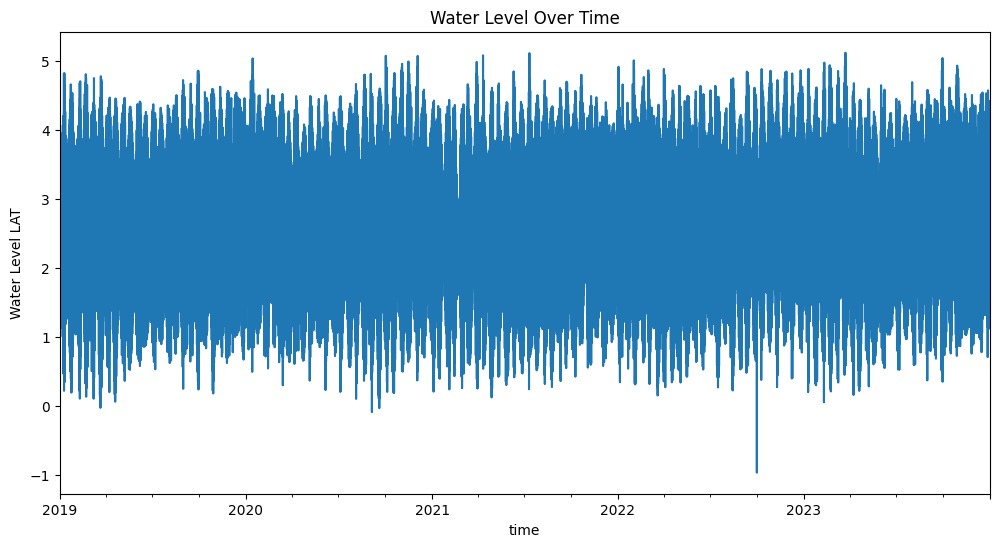

In [60]:
# 如果数据按时间索引
obs['Water_Level_LAT'].plot(figsize=(12, 6))
plt.title('Water Level Over Time')
plt.ylabel('Water Level LAT')
plt.show()


In [61]:
obs["anomaly"] = obs["Water_Level_LAT"] - obs["Water_Level_LAT"].mean()
obs["anomaly"] = obs["anomaly"].interpolate()

In [ ]:
obs["anomaly1"] = obs["Water_Level_LAT"]

In [62]:
coef = utide.solve(
    obs.index,
    obs["anomaly"],
    lat=-25,
    method="ols",
    conf_int="MC",
    verbose=False,
)

In [19]:
print(coef.keys())

dict_keys(['name', 'aux', 'nR', 'nNR', 'nI', 'weights', 'A', 'g', 'mean', 'slope', 'g_ci', 'A_ci', 'diagn', 'PE', 'SNR'])


In [63]:
tide = utide.reconstruct(obs.index, coef, verbose=False)

In [21]:
print(tide.keys())

dict_keys(['t_in', 'epoch', 'constit', 'min_SNR', 'min_PE', 't_mpl', 'h'])


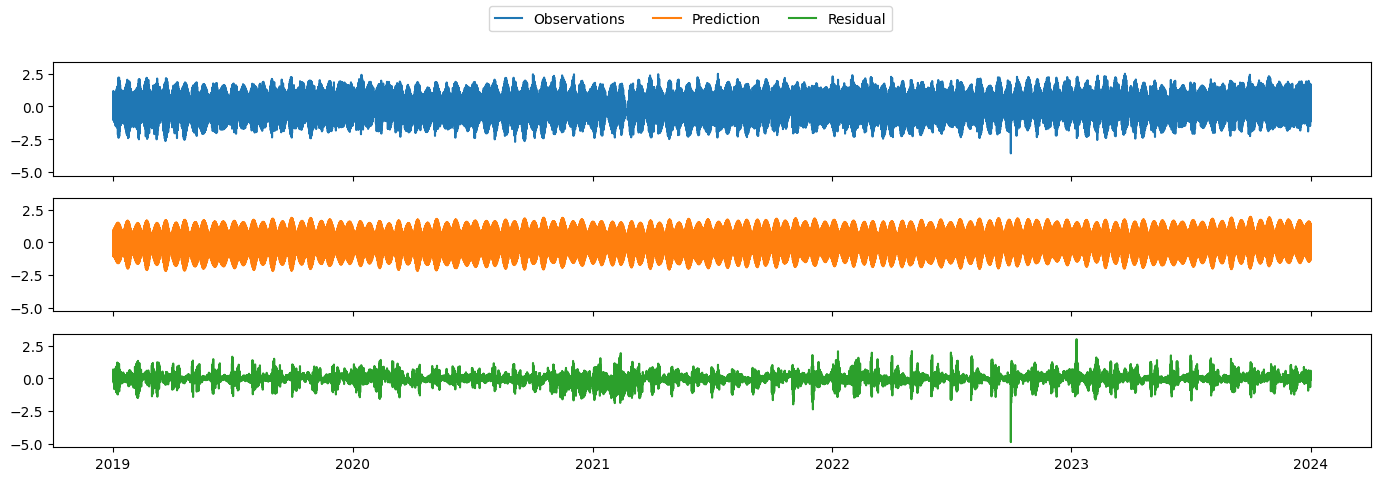

In [64]:
t = obs.index.to_pydatetime()

fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 5), nrows=3, sharey=True, sharex=True)

ax0.plot(t, obs.anomaly, label="Observations", color="C0")
ax1.plot(t, tide.h, label="Prediction", color="C1")
ax2.plot(t, obs.anomaly - tide.h, label="Residual", color="C2")
fig.legend(ncol=3, loc="upper center");

In [66]:
print(list(tide.h[:10]))

[-0.10271660904317156, -0.22978871241427068, -0.3538621032305652, -0.4725447931909092, -0.583724692597882, -0.6856638314966135, -0.7770209099062193, -0.8568040818217793, -0.9242732374758351, -0.9788233587589107]


In [67]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设您之前的代码已运行，得到了 obs DataFrame 和 tide.h

# 确保 obs.anomaly 和 tide.h 对齐
anomaly_series = obs['anomaly']
tide_series = pd.Series(tide.h, index=obs.index)

# 创建新的 DataFrame
result_df = pd.DataFrame({
    'time': obs.index,        # 时间列
    'anomaly': anomaly_series,
    'tide_h': tide_series
})

# 保存为 CSV 文件
result_df.to_csv('dataProcessed/ABE5Y1_HA_processed.csv', index=False)

print("数据已成功保存到 output.csv 文件中。")


数据已成功保存到 output.csv 文件中。


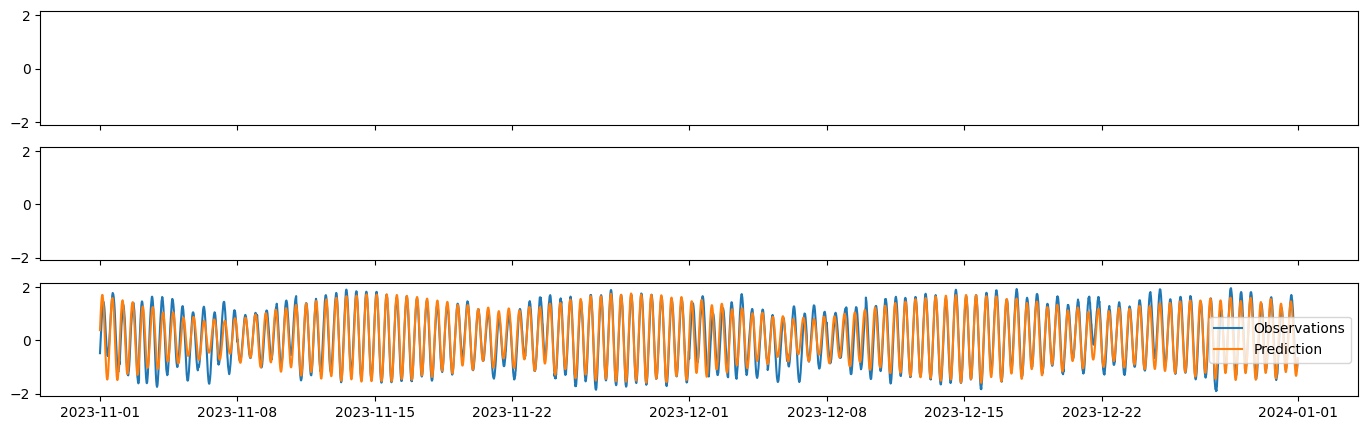

In [65]:
last_month = obs.loc['2023-11':'2024-01']
# 确保 last_month.index 与 obs.index 对齐，并找到索引位置
index_positions = obs.index.get_indexer(last_month.index)

# 使用这些索引位置从 tide.h 中提取对应的预测数据
pred_last_month = tide.h[index_positions]
t_last = last_month.index.to_pydatetime()
#pred_last_month = tide.h[last_month.index]
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 5), nrows=3, sharey=True, sharex=True)
plt.plot(t_last, last_month.anomaly, label="Observations", color="C0")
plt.plot(t_last, pred_last_month, label="Prediction", color="C1")
plt.legend()
plt.show()

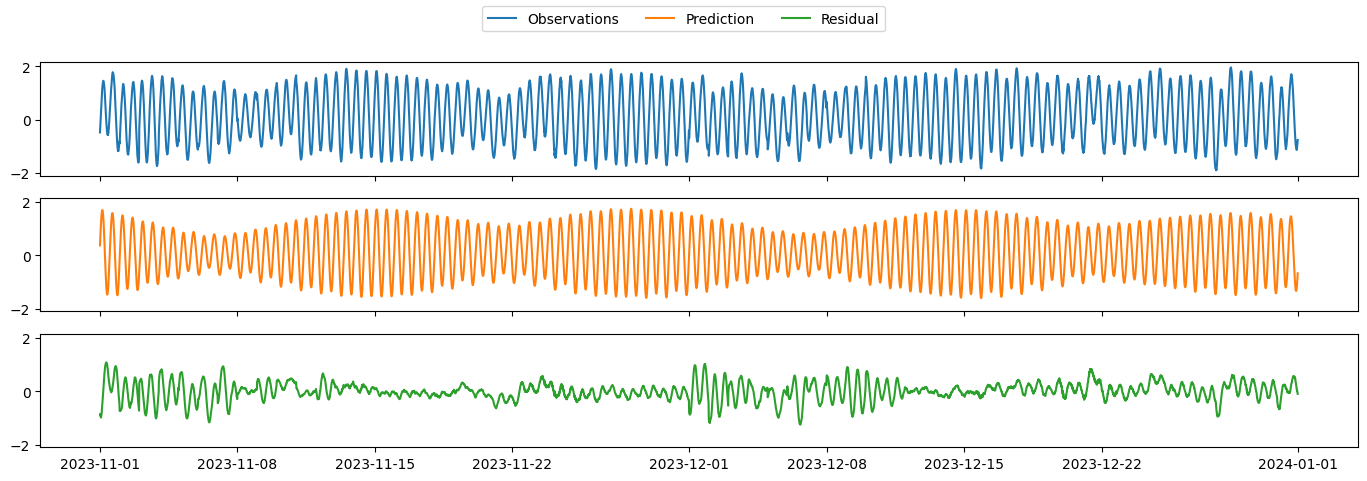

In [40]:
# 确保 last_month.index 与 obs.index 对齐，并找到索引位置
index_positions = obs.index.get_indexer(last_month.index)

# 使用这些索引位置从 tide.h 中提取对应的预测数据
pred_last_month = tide.h[index_positions]

# 计算最后一个月的残差
residual_last_month = last_month.anomaly - pred_last_month

# 绘制图像
t_last = last_month.index.to_pydatetime()
fig, (ax0, ax1, ax2) = plt.subplots(figsize=(17, 5), nrows=3, sharey=True, sharex=True)

ax0.plot(t_last, last_month.anomaly, label="Observations", color="C0")
ax1.plot(t_last, pred_last_month, label="Prediction", color="C1")
ax2.plot(t_last, residual_last_month, label="Residual", color="C2")

fig.legend(ncol=3, loc="upper center")
plt.show()

In [29]:
# 检查时间倒退
time_diff = obs.index.to_series().diff()
negative_diff = time_diff[time_diff < pd.Timedelta(0)]

if not negative_diff.empty:
    print("存在时间倒退的情况：")
    print(negative_diff)
else:
    print("没有时间倒退的情况。")


存在时间倒退的情况：
time
2019-01-13   -323 days +00:15:00
2019-01-02    -30 days +00:15:00
2019-02-13   -293 days +00:15:00
2019-01-03    -57 days +00:15:00
2019-03-13   -266 days +00:15:00
                     ...        
2023-01-10   -264 days +00:15:00
2023-10-13    -59 days +00:15:00
2023-01-11   -294 days +00:15:00
2023-11-13    -29 days +00:15:00
2023-01-12   -323 days +00:15:00
Name: time, Length: 110, dtype: timedelta64[ns]


In [33]:
# 假设您的数据已按时间索引设置
import pandas as pd

# 检查时间是否按升序排列
if obs.index.is_monotonic_increasing:
    print("时间按升序排列，没有时间倒退的情况。")
else:
    print("存在时间倒退的情况。")
    # 找出时间倒退的索引位置
    time_diff = obs.index.to_series().diff()
    negative_diff = time_diff[time_diff < pd.Timedelta(0)]
    print("时间倒退发生在以下位置：")
    print(negative_diff)


存在时间倒退的情况。
时间倒退发生在以下位置：
time
2019-01-13   -323 days +00:15:00
2019-01-02    -30 days +00:15:00
2019-02-13   -293 days +00:15:00
2019-01-03    -57 days +00:15:00
2019-03-13   -266 days +00:15:00
                     ...        
2023-01-10   -264 days +00:15:00
2023-10-13    -59 days +00:15:00
2023-01-11   -294 days +00:15:00
2023-11-13    -29 days +00:15:00
2023-01-12   -323 days +00:15:00
Name: time, Length: 110, dtype: timedelta64[ns]


In [34]:
# 假设您的数据已按时间索引设置
import pandas as pd

# 检查时间是否按升序排列
if obs.index.is_monotonic_increasing:
    print("时间按升序排列，没有时间倒退的情况。")
else:
    print("存在时间倒退的情况。")
    # 找出时间倒退的索引位置
    time_diff = obs.index.to_series().diff()
    negative_diff = time_diff[time_diff < pd.Timedelta(0)]
    print("时间倒退发生在以下位置：")
    print(negative_diff)



存在时间倒退的情况。
时间倒退发生在以下位置：
time
2019-01-13   -323 days +00:15:00
2019-01-02    -30 days +00:15:00
2019-02-13   -293 days +00:15:00
2019-01-03    -57 days +00:15:00
2019-03-13   -266 days +00:15:00
                     ...        
2023-01-10   -264 days +00:15:00
2023-10-13    -59 days +00:15:00
2023-01-11   -294 days +00:15:00
2023-11-13    -29 days +00:15:00
2023-01-12   -323 days +00:15:00
Name: time, Length: 110, dtype: timedelta64[ns]


In [ ]:
import numpy as np

# 确保 last_month.index 与 obs.index 对齐，并找到索引位置
index_positions = obs.index.get_indexer(last_month.index)

# 使用这些索引位置从 tide.h 中提取对应的预测数据
pred_last_month = tide.h[index_positions]

# 计算最后一个月的残差
residual_last_month = last_month.anomaly - pred_last_month

# 计算残差的平方（即误差平方）
mse_last_month = residual_last_month ** 2

# 计算整个时间段的平均 MSE
avg_mse = np.mean(mse_last_month)
print(f"Average MSE for last month: {avg_mse}")

# 绘制图像
t_last = last_month.index.to_pydatetime()
fig, (ax0, ax1, ax2, ax3) = plt.subplots(figsize=(17, 8), nrows=4, sharey=False, sharex=True)

ax0.plot(t_last, last_month.anomaly, label="Observations", color="C0")
ax1.plot(t_last, pred_last_month, label="Prediction", color="C1")
ax2.plot(t_last, residual_last_month, label="Residual", color="C2")
ax3.plot(t_last, mse_last_month, label="MSE", color="C3")

fig.legend(ncol=4, loc="upper center")
plt.show()


In [35]:
# 对数据按时间进行升序排序
obs = obs.sort_index()


In [53]:
import pandas as pd
import numpy as np

# 读取csv文件
file_path = 'dataProcessed/ABE5Y1.csv'
output_path = 'dataProcessed/ABE5Y1_processed.csv'

# 读取数据
df = pd.read_csv(file_path)

# 确保time列是时间格式
df['time'] = pd.to_datetime(df['time'], errors='coerce')

# 删除无法解析的时间行
df = df.dropna(subset=['time'])

# 排序时间，修复时间倒退
df = df.sort_values(by='time')

# 移除重复时间
df = df.drop_duplicates(subset='time')

# 重置索引
df = df.reset_index(drop=True)

# 处理Water_Level_LAT列中小于-20的值
df['Water_Level_LAT'] = df['Water_Level_LAT'].apply(lambda x: np.nan if x < -20 else x)

# 使用插值法填充缺失值
df['Water_Level_LAT'] = df['Water_Level_LAT'].interpolate(method='linear')

# 再次处理插值后可能产生的边界缺失值
df['Water_Level_LAT'] = df['Water_Level_LAT'].fillna(method='bfill').fillna(method='ffill')

# 保存处理后的文件
df.to_csv(output_path, index=False)

print(f"处理完成，文件已保存到 {output_path}")


处理完成，文件已保存到 dataProcessed/ABE5Y1_processed.csv
